# FNN Linus Etemi

## Imports


In [15]:
TYPE = 'GPU'

if TYPE == 'CPU':
    import numpy as np
else:
    import cupy as np
    
import scipy.special
import math
import matplotlib
import matplotlib.pyplot as matplot
import pickle

from ray import tune
from csv import writer


## Config

In [16]:
#hiddennodes_start = 800
#hiddennodes_stop = 800
#hiddennodes_step = 100

#learningrate_start = 0.08
#learningrate_stop = 0.08
#learningrate_step = 0.01

#epochs_start = 1
#epochs_stop = 2
#epochs_step = 0

outputnodes = 10
hiddennodes = 900
learningrate = 0.05
inputnodes = 784
epochs= 1


## Neuronales Netz 

In [17]:
class neuralNetwork:
    def __init__(self, innodes, outnodes, hidnodes, learningrate, epochs):
        self.inodes = innodes
        self.onodes = outnodes
        self.hnodes = hidnodes
        self.lr = learningrate
        self.epo = epochs
        self.wih = ((np.random.rand(self.hnodes,self.inodes)*2)-1)
        self.who = ((np.random.rand(self.onodes,self.hnodes)*2)-1)
        pass
    
    def activation_function(self, z: int) -> classmethod:
        return 1 / (1 + np.exp(-z))

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)

        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors) 
        self.who += self.lr * np.dot( (output_errors*final_outputs*(1.0-final_outputs)), np.transpose(hidden_outputs)) 
        self.wih += self.lr * np.dot( (hidden_errors*hidden_outputs*(1.0-hidden_outputs)), np.transpose(inputs)) 
        pass

    def query(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    

    

In [18]:
def clear_content(fname: str) -> None:
    file = open(fname, "w+")
    file.close

## Train_Network

In [19]:
def train_network(n, net, epo):  

        clear_content('mnist_second_train.csv')
        training_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()

        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')

                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n.train(inputs, targets)

                pass
            pass



## Train_Network 2


In [20]:
# def train_network(n, net, epo):  
#         if(net == 1):
#             n.clear_content('mnist_second_train.csv')
#             training_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
#             training_data_list = training_data_file.readlines()
#             training_data_file.close()
#         elif(net == 2):
#             training_data_file = open("./mnist_second_train.csv", 'r')
#             training_data_list = training_data_file.readlines()
#             training_data_file.close()
#         for e in range(epo):
#             for record in training_data_list:
#                 all_values = record.split(',')

#                 inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
#                 targets = np.zeros(outputnodes) + 0.01
#                 targets[int(all_values[0])] = 0.99
#                 n.train(inputs, targets)

#                 pass
#             pass


## Test_Network

In [21]:
def test_network(n):

    test_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    array_data_all = []
    scorecard_p = []    
    scorecard_q = []

    for i in range(100):
        array_data_all.append([])
        scorecard_p.append([])
        scorecard_q.append([])

    for record in test_data_list:
        all_values = record.split(',')
        correct_label = int(all_values[0])
        inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
        outputs = n.query(inputs)
        label_max = outputs[np.argmax(outputs)]
        label = np.argmax(outputs)

        for threshold in range(100):
            if(label_max > (threshold/100)):
                scorecard_p[threshold].append(1)
                if(label == correct_label):
                    scorecard_q[threshold].append(1)
                else:
                    scorecard_q[threshold].append(0)
            else:
                scorecard_p[threshold].append(0)
                #zweite netz werte 

    for i in range(100):
        scorecard_p_array = np.asarray(scorecard_p[i])
        scorecard_q_array = np.asarray(scorecard_q[i])

        array_data_all[i].append(i/100)
        array_data_all[i].append('P: {:.5f}'.format(scorecard_p_array.sum()/scorecard_p_array.size))
        array_data_all[i].append('Q: {:.5f}'.format(scorecard_q_array.sum()/scorecard_q_array.size))


    return array_data_all

## Test2

In [22]:
#def test_network2(n):
    # test_data_file = open("./mnist_accepted.csv", 'r')
    # test_data_list = test_data_file.readlines()
    # test_data_file.close()

    # scorecard_train = []

    # for record in test_data_list:

    #         all_values = record.split(',')
    #         correct_label = int(all_values[0])
    #         inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
    #         outputs = n.query(inputs)
    #         score = outputs[np.argmax(outputs)]

    #         if(np.argmax(outputs) == correct_label):
    #             scorecard_train.append(1)
    #         else:
    #             scorecard_train.append(0)
    #             append_list_as_row('mnist_second_train.csv', list(map(int, all_values)))
                    


    # scorecard_train_array = np.asarray(scorecard_train)
    # performance2 = scorecard_train_array.sum() / scorecard_train_array.size

    # return performance2

## CSV Writer und Grid Search

In [23]:
def append_list_as_row(fname,list_of_elem):
    with open(fname, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)

In [24]:
#learningrate_i = learningrate_start
#hiddennodes_i = hiddennodes_start
#epochs_i = epochs_start


#while epochs_i <= epochs_stop:
#    while hiddennodes_i <= hiddennodes_stop:
#        while learningrate_i <= learningrate_stop:
#            intermediate_score = neuralNetwork(784,10,hiddennodes_i,learningrate_i,epochs_i).test_train()
#            print('Epoch [{:02d}/{:02d}]     | Hidden_Nodes [{:04d}/{:04d}]     | Learning_Rate [{:.2f}/{:.2f}]     | Performance: {:.5f}'.format(epochs_i,epochs_stop,hiddennodes_i,hiddennodes_stop,learningrate_i,learningrate_stop,intermediate_score))
#            append_list_as_row([784,10,hiddennodes_i,learningrate_i,epochs_i,intermediate_score])
#            learningrate_i += learningrate_step 
#        learningrate_i = learningrate_start    
#        hiddennodes_i += hiddennodes_step
#        print("========================================================")
#    hiddennodes_i = hiddennodes_start
#    epochs_i += epochs_step
#    print("========================================================")

## Scoring und Aufruf von Beiden Netzen

In [25]:

n1 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
#train_network(n1, network_number, epochs)
#pickle.dump(n1, open('neural_network_1.obj', 'wb'))
n1 = pickle.load(open('neural_network_1.obj', 'rb'))

intermediate_score1 = test_network(n1)
print(intermediate_score1)


# network_number=2
# n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
# train_network(n2, network_number, epochs)
# intermediate_score2 = test_network(n2, network_number)
# print(intermediate_score2)


[[0.0, 'P: 1.00000', 'Q: 0.95761'], [0.01, 'P: 0.99988', 'Q: 0.95760'], [0.02, 'P: 0.99974', 'Q: 0.95770'], [0.03, 'P: 0.99953', 'Q: 0.95785'], [0.04, 'P: 0.99921', 'Q: 0.95802'], [0.05, 'P: 0.99893', 'Q: 0.95825'], [0.06, 'P: 0.99842', 'Q: 0.95855'], [0.07, 'P: 0.99781', 'Q: 0.95889'], [0.08, 'P: 0.99714', 'Q: 0.95911'], [0.09, 'P: 0.99611', 'Q: 0.95970'], [0.1, 'P: 0.99530', 'Q: 0.96013'], [0.11, 'P: 0.99427', 'Q: 0.96066'], [0.12, 'P: 0.99336', 'Q: 0.96114'], [0.13, 'P: 0.99226', 'Q: 0.96177'], [0.14, 'P: 0.99099', 'Q: 0.96221'], [0.15, 'P: 0.98977', 'Q: 0.96269'], [0.16, 'P: 0.98831', 'Q: 0.96338'], [0.17, 'P: 0.98726', 'Q: 0.96397'], [0.18, 'P: 0.98590', 'Q: 0.96456'], [0.19, 'P: 0.98448', 'Q: 0.96531'], [0.2, 'P: 0.98345', 'Q: 0.96585'], [0.21, 'P: 0.98209', 'Q: 0.96649'], [0.22, 'P: 0.98074', 'Q: 0.96704'], [0.23, 'P: 0.97924', 'Q: 0.96755'], [0.24, 'P: 0.97786', 'Q: 0.96802'], [0.25, 'P: 0.97646', 'Q: 0.96849'], [0.26, 'P: 0.97517', 'Q: 0.96922'], [0.27, 'P: 0.97340', 'Q: 0.970

## Plotting

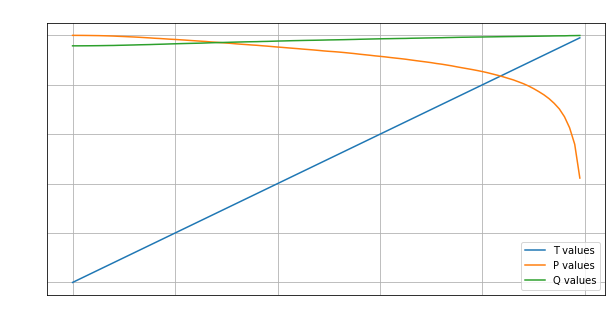

In [73]:
l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
t_values = []
p_values = []
q_values = []
import numpy as np

for i in range(100):
    speicher = intermediate_score1[i]
    t_values.append(speicher[0])
    p_values.append(speicher[1])
    q_values.append(speicher[2])

p_int_values = [s.replace("P:","")for s in p_values]
p_int_values = list(map(float, p_int_values))
q_int_values = [t.replace("Q:","")for t in q_values]
q_int_values = list(map(float, q_int_values))
N = len(t_values)
l2 = np.arange(N)

with matplot.rc_context({'axes.edgecolor': 'black', 'xtick.color':'white','ytick.color':'white'}):
    matplot.subplots(figsize=(10,5))
    matplot.plot(l2, t_values, label='T values')
    matplot.plot(l2, p_int_values, label='P values')
    matplot.plot(l2, q_int_values, label='Q values')

    matplot.grid(True)
    matplot.xlabel("%", fontsize = 12, color = 'white')
    matplot.colorbar
    matplot.ylabel("%", fontsize = 12, color = 'white')
    matplot.legend()
    matplot.title("P & Q & T Values", fontsize = 12, color = 'white')
    matplot.show()


